FFT on a sample an P-Welch

In [136]:
import numpy as np
import pandas as pd


import statsmodels.api as sm
import scipy.stats as stats
import scipy.signal as signal

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

In [137]:
# config and constants
sns.set()

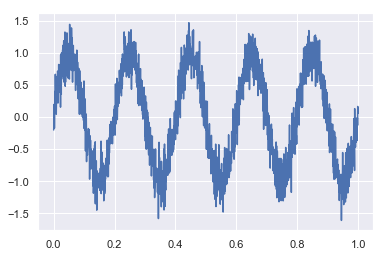

In [148]:
def test_signal(signal_frequency=5, sample_rate=2e3, sigma = None):
    signal_len = 1
    dt = signal_len / sample_rate
    t = np.arange(0, signal_len, dt)
    
    
    if sigma is None:
        noise = 0 
    else:
        noise = sigma * np.random.randn(len(t))
    
    w = signal_frequency*2*np.pi
    x = np.sin(w*t)
    
    
    
    
    srs = pd.Series(x + noise, index=t, name='signal')
    return srs
srs = test_signal(sigma=0.2)

srs.plot();

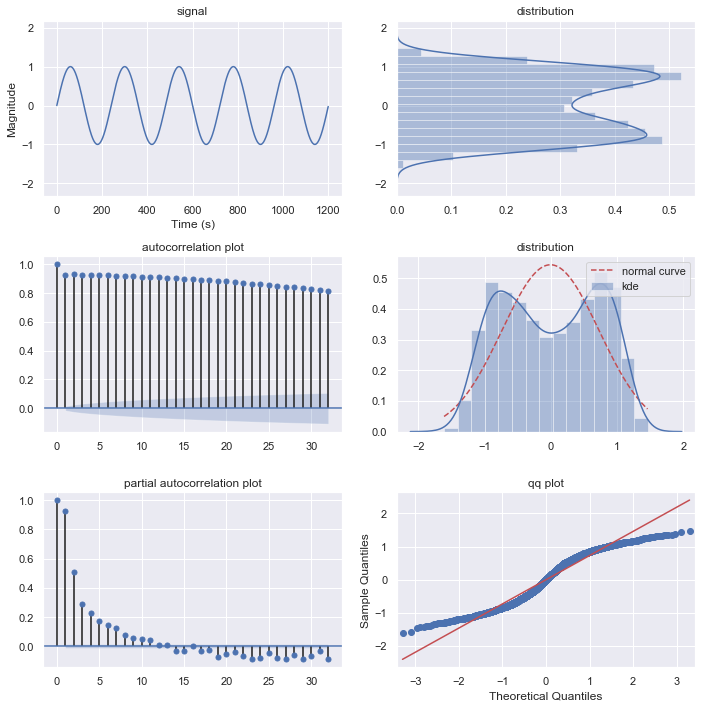

In [149]:
def plot_diagnostics(srs, lags=None):
    """
    visualise the correlations
    i can't remember where i found this combination of plots but it's a pretty useful set of plots
    [         signal        ]
    [    autocorrelation    ]
    [partial autocorrelation]
    [        qq plot        ]
    
    """ 
    #constants
    mu = srs.mean()
    sigma = srs.std()
    srs_max = srs.max()
    srs_min = srs.min()
    
    # set up axis
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(3, 2, fig)
    
    # set axes
    srs_ax = plt.subplot(gs[0, 0]) # axis for plotting signal
    vdist_ax = plt.subplot(gs[0, 1], sharey=srs_ax) # axis for plotting distribution next to signal
    hdist_ax = plt.subplot(gs[1, 1]) # axis for plotting distribution above qqplot
    qqplot_ax = plt.subplot(gs[2, 1]) # qq plot axis
    
    acf_ax = plt.subplot(gs[1, 0]) # autocorrelation axis
    pacf_ax = plt.subplot(gs[2, 0]) # partial autocorrelation axis
    
    # plot signal
    srs_ax.plot(y)
    srs_ax.set_title("signal")
    srs_ax.set_xlabel("Time (s)") 
    srs_ax.set_ylabel("Magnitude")
    
    # v distribution
    sns.distplot(srs, norm_hist=True, vertical=True, ax=vdist_ax); # plot the distribution
    vdist_ax.set_title("distribution")
    vdist_ax.set_ylabel(None)
    vdist_ax.set_xlabel(None)
    
    # h distribution
    xx = np.arange(srs_min, srs_max, 0.01)                                                   
    yy = stats.norm.pdf(xx, mu, sigma)  
    
    hdist_ax.plot(xx, yy, 'r--', label='normal curve')
    sns.distplot(srs, norm_hist=True, vertical=False, ax=hdist_ax, label='kde'); # plot the distribution
    
    hdist_ax.set_title("distribution")
    hdist_ax.set_ylabel(None)
    hdist_ax.set_xlabel(None)
    hdist_ax.legend(loc='upper right')
    
    # qq plot
    sm.qqplot(srs, line='s', dist='norm', ax=qqplot_ax)
    qqplot_ax.set_title("qq plot")
    
    # acf plot
    sm.tsa.graphics.plot_acf(srs, ax =acf_ax, lags=lags, alpha=0.5)
    acf_ax.set_title("autocorrelation plot")
    
    # pacf plot
    sm.tsa.graphics.plot_pacf(srs, ax=pacf_ax, lags=lags, alpha=0.5)
    pacf_ax.set_title("partial autocorrelation plot")
    
    plt.tight_layout()
    
plot_diagnostics(srs, lags=32)

lets look at sampling the signal and performing ffts on the signal

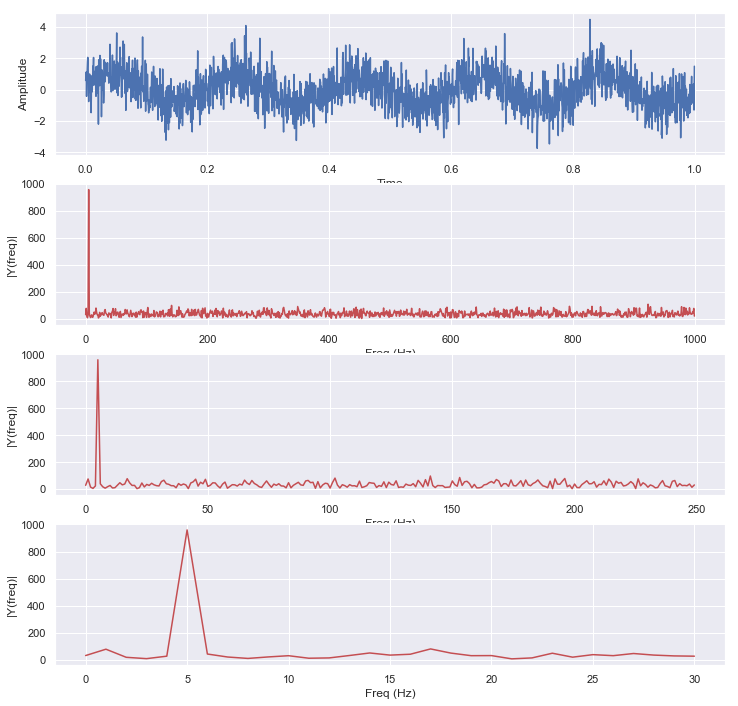

In [151]:
def plot_fft(srs):
    dt = srs.index[1] - srs.index[0]
    
    Y = np.fft.fft(srs)
    frq = np.fft.fftfreq(srs.shape[0], dt)
    
    fig = plt.figure(figsize=(12,12))
    gs = gridspec.GridSpec(4, 1, figure=fig)
    
    srs_ax = plt.subplot(gs[0, 0])
    fft_lores_ax = plt.subplot(gs[1, 0])
    fft_hires_ax = plt.subplot(gs[2, 0])
    fft_vhres_ax = plt.subplot(gs[3, 0])
    
    srs_ax.plot(srs)
    srs_ax.set_xlabel('Time')
    srs_ax.set_ylabel('Amplitude')
    fft_lores_ax.plot(frq[range(len(Y)//2)],abs(Y[range(len(Y)//2)]),'r') # plotting the spectrum
    fft_lores_ax.set_xlabel('Freq (Hz)')
    fft_lores_ax.set_ylabel('|Y(freq)|')
    
    fft_hires_ax.plot(frq[range(len(Y)//8)],abs(Y[range(len(Y)//8)]),'r') # plotting the spectrum
    fft_hires_ax.set_xlabel('Freq (Hz)')
    fft_hires_ax.set_ylabel('|Y(freq)|')
    
    fft_vhres_ax.plot(frq[range(len(Y)//64)],abs(Y[range(len(Y)//64)]),'r') # plotting the spectrum
    fft_vhres_ax.set_xlabel('Freq (Hz)')
    fft_vhres_ax.set_ylabel('|Y(freq)|')
    
sample_signal_srs = test_signal(sigma=0.9)

plot_fft(sample_signal_srs)


In [152]:
f, Pxx_den = signal.welch(sample_signal_srs)

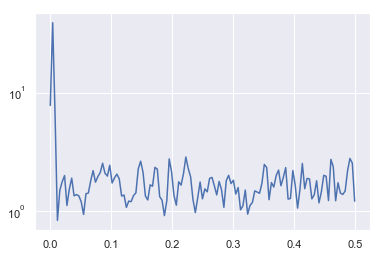

In [153]:
plt.semilogy(f, Pxx_den)

In [155]:
f, Pxx_den = signal.periodogram(sample_signal_srs)

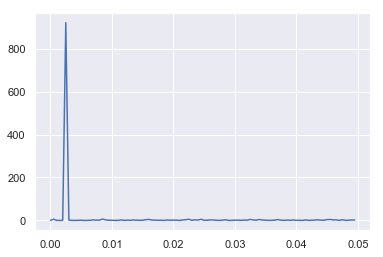

In [161]:
plt.plot(f[0:100], Pxx_den[0:100])